In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
%matplotlib inline

In [3]:
def mv(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
class Config():
    def __init__(self, nS, nA):
        self.Vmin = -0.1
        self.Vmax = 1.1
        self.nAtoms = 51
        self.nS = nS
        self.nA = nA
        self.gamma = 0.99

In [5]:
class C51():
    def __init__(self, config, uniform=False):
        self.config = config
        self.p = np.ones((self.config.nS, self.config.nA,\
                        self.config.nAtoms)) * 1.0/self.config.nAtoms
        if not uniform:
            self.p[:, :, 0] = 10
            for x in range(self.config.nS):
                for a in range(self.config.nA):
                    self.p[x, a, :] /= np.sum(self.p[x, a, :])
        self.dz = (self.config.Vmax - self.config.Vmin)/(self.config.nAtoms-1)
        self.z = np.arange(self.config.nAtoms) * self.dz + self.config.Vmin
    def observe(self, x, a, r, nx, terminal, alpha):
        Q_nx = np.zeros(self.config.nA)
        for at in range(self.config.nA):
            Q_nx[at] = np.sum(self.p[nx, at, :] * self.z)
        a_star = np.argmax(Q_nx)
        m = np.zeros(self.config.nAtoms)
        for i in range(self.config.nAtoms):
            if not terminal:
                tz = np.clip(r + self.config.gamma*self.z[i],\
                        self.config.Vmin, self.config.Vmax)
            else:
                tz = np.clip(r,\
                        self.config.Vmin, self.config.Vmax)
            b = (tz - self.config.Vmin)/self.dz
            l = int(np.floor(b)); u = int(np.ceil(b))
            m[l] += self.p[nx, a_star,i] * (u-b)
            m[u] += self.p[nx, a_star,i] * (b-l)
        self.p[x, a, :] = self.p[x, a, :] + alpha * (m - self.p[x, a, :]) ##### How ####
        self.p[x, a, :] /= np.sum(self.p[x, a, :])
    def Q(self, x):
        Q_nx = np.zeros(self.config.nA)
        for at in range(self.config.nA):
            Q_nx[at] = np.sum(self.p[x, at, :] * self.z)
        return Q_nx
    def CVaR(self, x, alpha, N=20):
        Q = np.zeros(self.config.nA)
        for a in range(self.config.nA):
            values = np.zeros(N)
            for n in range(N):
                tau = np.random.uniform(0, alpha)
                idx = np.argmax((np.cumsum(self.p[x, a, :]) > tau) * 1.0)
                z = self.z[idx]
                values[n] = z
            Q[a] = np.mean(values)
        return Q
    def plot(self, x, a):
        plt.plot(self.z, self.p[x, a, :], '.')

In [6]:
class Qlearning():
    def __init__(self, config):
        self.config = config
        self.Q = np.zeros((self.config.nS, self.config.nA))
    def observe(self, x, a, r, nx, alpha):
        self.Q[x, a] = self.Q[x, a] + alpha * \
        (r + self.config.gamma * np.max(self.Q[nx, :]) - self.Q[x, a])

In [615]:
env = gym.make('FrozenLake-v0')
config = Config(env.observation_space.n, env.action_space.n)
c51 = C51(config)
q = Qlearning(config)

num_episode = 5000
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.1, 0.9 + ep * ((0 - 0.9)/(num_episode)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/5)))
    o = env.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(env.action_space.n)
        else:
            a = np.argmax(c51.Q(o))
            #a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal, _ = env.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        q.observe(o, a, r, no, alpha)
        o = no
    returns[ep] = ret

Text(0,0.5,'Return')

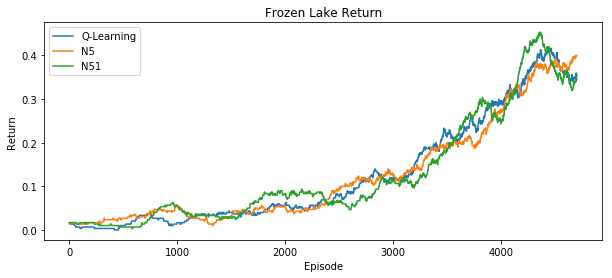

In [619]:
plt.figure(figsize=(10, 4))
plt.title('Frozen Lake Return')
plt.plot(mv(np.load('q.npy'), 300), label = 'Q-Learning')
plt.plot(mv(np.load('qC51N5.npy'), 300), label = 'N5')
plt.plot(mv(np.load('qC51N51.npy'), 300), label = 'N51')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')

Text(0,0.5,'Prob')

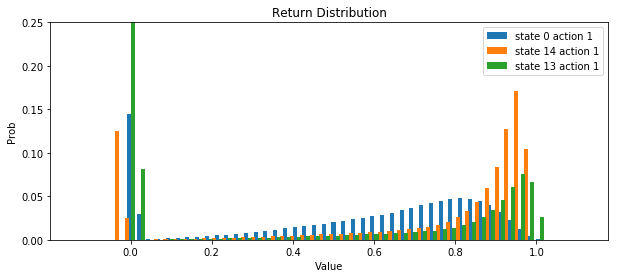

In [545]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[0, 0, :], width = 0.01, label = 'state 0 action 1', linewidth = 5)
plt.bar(c51.z - 0.03, c51.p[14, 0, :], width = 0.01, label = 'state 14 action 1', linewidth = 5)
plt.bar(c51.z + 0.01, c51.p[13, 0, :], width = 0.01, label = 'state 13 action 1', linewidth = 5)
plt.ylim([0, 0.25])
plt.legend()
plt.xlabel('Value')
plt.ylabel('Prob')

In [44]:
### New Envinronemt
def dist(word, method, trial = 100, CVaR =False, alpha=0.1):
    returns = np.zeros(trial)
    for ep in range(trial):
        ret = 0
        o = world.reset()
        terminal=False
        while not terminal:
            #a = np.argmax(method.Q(o))
            if CVaR:
                a = np.argmax(method.CVaR(o, alpha=alpha, N=50))
            no, r, terminal = world.step(a) 
            o = no
            ret+=r
        returns[ep] = ret
    return returns

In [7]:
from env import Gridworld

In [7]:
world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)

config = Config(world.nS, world.nA)
config.Vmin = -7; config.Vmax = 1
c51 = C51(config)
q = Qlearning(config)

num_episode = 2000
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.1, 0.9 + ep * ((0 - 0.9)/(num_episode/2)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(world.nA)
        else:
            a = np.argmax(c51.Q(o))
            #a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal = world.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        q.observe(o, a, r, no, alpha)
        o = no
    returns[ep] = ret

Text(0,0.5,'Return')

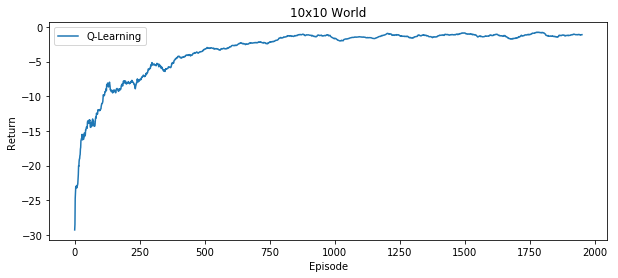

In [9]:
plt.figure(figsize=(10, 4))
plt.title('10x10 World')
plt.plot(mv(returns, 50), label = 'Q-Learning')
#plt.plot(mv(np.load('q.npy'), 300), label = 'Q-Learning')
#plt.plot(mv(np.load('qC51N5.npy'), 300), label = 'N5')
#plt.plot(mv(np.load('qC51N51.npy'), 300), label = 'N51')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')

Text(0,0.5,'Prob')

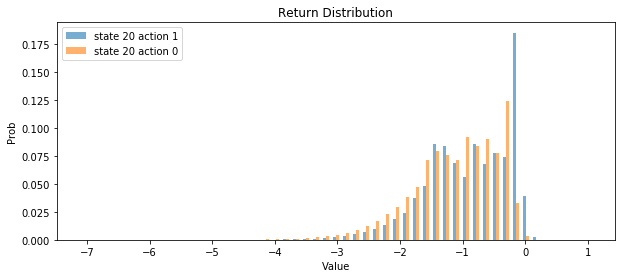

In [12]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
#plt.bar(c51.z, c51.p[12, 2, :], width=0.01, label = 'state 20 action 2', linewidth = 5, alpha=0.6)
plt.bar(c51.z-0.05, c51.p[12, 1, :], width=0.05, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[12, 0, :], width=0.05, label = 'state 20 action 0', linewidth = 5, alpha=0.6)
plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

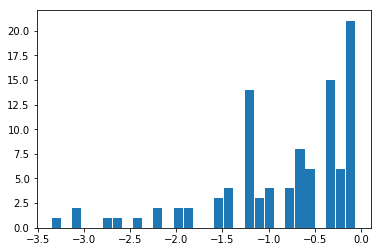

In [25]:
distribution = dist(world, c51, CVaR=False)
plt.hist(distribution, bins=30, width=0.1);

In [26]:
## Now CVaR -- 0.1

In [75]:
world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)

config = Config(world.nS, world.nA)
config.Vmin = -7; config.Vmax = 1
c51 = C51(config)
q = Qlearning(config)

num_episode = 2000
returns = np.zeros(num_episode)
CVaRs = np.zeros((num_episode, world.nA))
for ep in range(num_episode):
    terminal = False
    e = max(0.1, 0.9 + ep * ((0 - 0.9)/(num_episode/2)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    o_init = o
    CVaRs[ep, :] = c51.CVaR(o_init, alpha=0.05, N=100)
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(world.nA)
        else:
            #a = np.argmax(c51.Q(o))
            a = np.argmax(c51.CVaR(o, alpha=0.05, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal = world.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        q.observe(o, a, r, no, alpha)
        o = no
    returns[ep] = ret

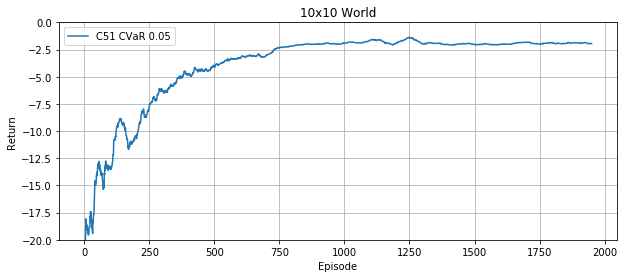

In [72]:
plt.figure(figsize=(10, 4))
plt.title('10x10 World')
plt.plot(mv(returns, 50), label = 'C51 CVaR 0.05')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid()
plt.ylim([-20, 0]);

(0, 500)

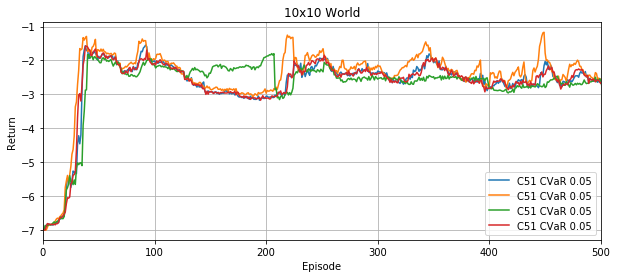

In [87]:
plt.figure(figsize=(10, 4))
plt.title('10x10 World')
plt.plot(mv(CVaRs[:, 0], 1), label = 'C51 CVaR 0.05')
plt.plot(mv(CVaRs[:, 1], 1), label = 'C51 CVaR 0.05')
plt.plot(mv(CVaRs[:, 2], 1), label = 'C51 CVaR 0.05')
plt.plot(mv(CVaRs[:, 3], 1), label = 'C51 CVaR 0.05')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid()
#plt.ylim([-20, 0]);
plt.xlim([0, 500])

In [88]:
np.save('C51CVaRs.npy', CVaRs)

In [73]:
# np.save('C51CVaR05return.npy', returns)
# np.save('C51CVaR05p.npy', c51.p)

Text(0,0.5,'Prob')

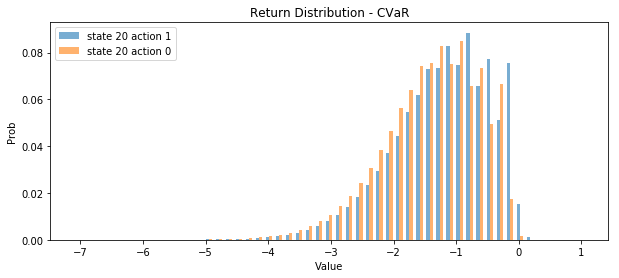

In [58]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution - CVaR')
#plt.bar(c51.z, c51.p[12, 2, :], width=0.01, label = 'state 20 action 2', linewidth = 5, alpha=0.6)
plt.bar(c51.z-0.05, c51.p[12, 1, :], width=0.05, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[12, 0, :], width=0.05, label = 'state 20 action 0', linewidth = 5, alpha=0.6)
plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

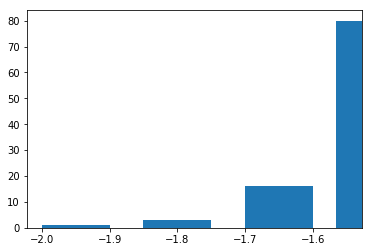

In [59]:
distributionCVaR = dist(world, c51, CVaR=True, alpha=0.05)
plt.hist(distributionCVaR, bins=30, width=0.1);

In [50]:
o = world.reset()
terminal=False
while not terminal:
    a = np.argmax(c51.CVaR(o, alpha=0.1, N=50))
    no, r, terminal = world.step(a) 
    o = no
    world._render()

##########
#0ssssssg#
#Xjjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
#Xssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#X ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#X  ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#X       #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
# X      #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#  X     #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#   X    #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#    X   #
#        #
#        #
##########

#

In [32]:
# Now CVaR 0.25

In [39]:
world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)

config = Config(world.nS, world.nA)
config.Vmin = -7; config.Vmax = 1
c51 = C51(config)
q = Qlearning(config)

num_episode = 2000
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.1, 0.9 + ep * ((0 - 0.9)/(num_episode/2)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(world.nA)
        else:
            #a = np.argmax(c51.Q(o))
            a = np.argmax(c51.CVaR(o, alpha=0.5, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal = world.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        q.observe(o, a, r, no, alpha)
        o = no
    returns[ep] = ret

Text(0,0.5,'Prob')

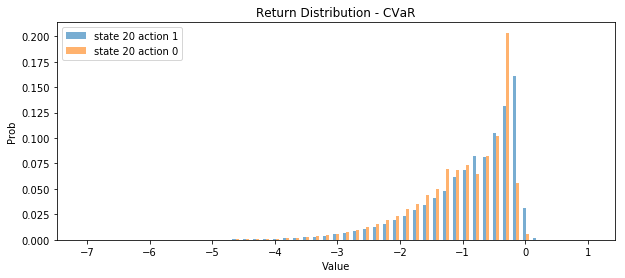

In [40]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution - CVaR')
#plt.bar(c51.z, c51.p[12, 2, :], width=0.01, label = 'state 20 action 2', linewidth = 5, alpha=0.6)
plt.bar(c51.z-0.05, c51.p[12, 1, :], width=0.05, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[12, 0, :], width=0.05, label = 'state 20 action 0', linewidth = 5, alpha=0.6)
plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

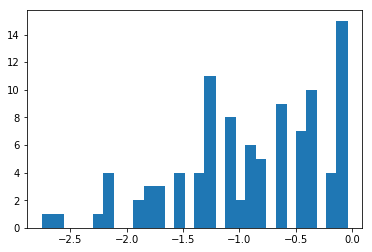

In [46]:
distributionCVaR2 = dist(world, c51, CVaR=True, alpha=0.5)
plt.hist(distributionCVaR2, bins=30, width=0.1);

In [43]:
o = world.reset()
terminal=False
while not terminal:
    a = np.argmax(c51.CVaR(o, alpha=0.5, N=50))
    no, r, terminal = world.step(a) 
    o = no
    world._render()

##########
#0Xsssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sXssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0Xsssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sXssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssXsssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sssXssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjXjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjXj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjX #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

#

Text(0.5,0,'return')

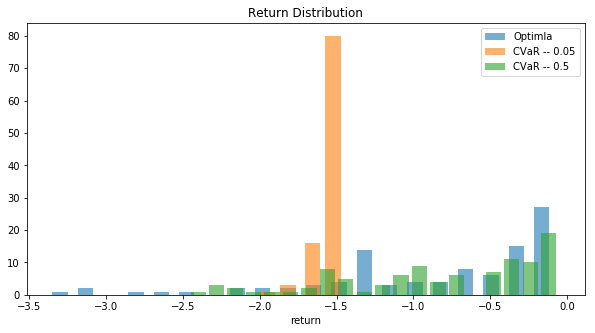

In [68]:
plt.figure(figsize=(10,5))
plt.hist(distribution, bins=20, width=0.1, label = 'Optimla', alpha = 0.6);
plt.hist(distributionCVaR, bins=20, width=0.1, label = 'CVaR -- 0.05', alpha = 0.6);
plt.hist(distributionCVaR2, bins=20, width=0.1, label = 'CVaR -- 0.5', alpha = 0.6);
plt.legend()
plt.title('Return Distribution')
plt.xlabel('return')

### How fast we learn this policy?

In [ ]:
world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)
b_num = 10
config = Config(world.nS, world.nA)
config.Vmin = -7; config.Vmax = 1
c51 = []
for b in range(b_num):
    c51.append(C51(config, uniform = True))

num_episode = 1000
returns = np.zeros(num_episode)
#CVaRs = np.zeros((num_episode, world.nA))
for ep in range(num_episode):
    terminal = False
    e = max(0.1, 0.9 + ep * ((0 - 0.9)/(num_episode/2)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    o_init = o
    ret = 0
    while not terminal:
        Qlist = np.array([x.CVaR(o, alpha=0.05, N=50) for x in c51])
        best = np.max(Qlist, axis = 0)
        a = np.argmax(best)
        network = np.argmax(Qlist[:, a])
        no, r, terminal = world.step(a) 
        ret += r
        c51[network].observe(o, a, r, no, terminal, alpha)
        o = no
    returns[ep] = ret
    print(ep)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138


In [162]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution - CVaR')
plt.bar(c51[0].z-0.05, c51[2].p[12, 3, :], width=0.05, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

[array([-3., -3., -3., -3.]),
 array([-3., -3., -3., -3.]),
 array([-3., -3., -3., -3.]),
 array([-3., -3., -3., -3.]),
 array([-3., -3., -3., -3.]),
 array([-3., -3., -3., -3.]),
 array([-3., -3., -3., -3.]),
 array([-3., -3., -3., -3.]),
 array([-3., -3., -3., -3.]),
 array([-3., -3., -3., -3.])]

[2019-02-22 17:59:34,965] No handles with labels found to put in legend.


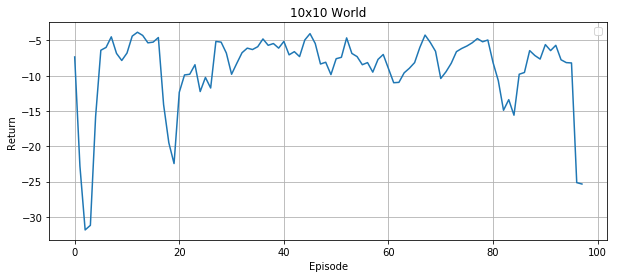

In [147]:
plt.figure(figsize=(10, 4))
plt.title('10x10 World')
plt.plot(mv(returns, 3))
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid()
#plt.ylim([-20, 0]);

### Trash

In [610]:
### Running the same thing with CVaR action selection

In [620]:
### We need a new envinronemnt for CVaR, since the forzen lake is not okay! ###

In [6]:
from cliffwalker import *

In [81]:
env = GridWorld(5, 5, random_action_p=0.3)
config = Config(env.nS, env.nA)
config.Vmin = -30; config.Vmax = -2; config.gamma = 0.99; config.nAtoms=51
c51 = C51(config)
q = Qlearning(config)

num_episode = 2500
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.05, 1 + ep * ((0 - 9)/(num_episode)))
    alpha = max(0.001, 0.9 + ep * ((0 - 0.9)/(num_episode)))
    o = env.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(env.nA)
        else:
            a = np.argmax(c51.Q(o))
            #a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal = env.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        #q.observe(o, a, (r/100)+1, no, alpha)
        o = no
    returns[ep] = ret

In [149]:
np.save('cliffwalkerQlearning.npy', returns)

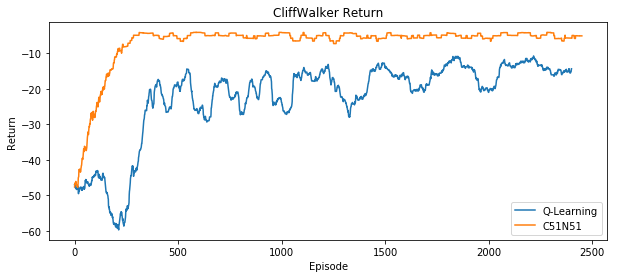

In [82]:
plt.figure(figsize=(10, 4))
plt.title('CliffWalker Return')
plt.plot(mv(np.load('cliffwalkerQlearning.npy'), 100), label = 'Q-Learning')
#plt.plot(mv(np.load('cliffwalkerC51N51q.npy'), 200), label = 'C51N51')
plt.plot(mv(returns, 50), label = 'C51N51')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return');

Text(0,0.5,'Prob')

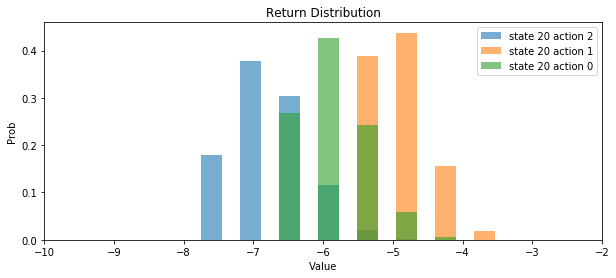

In [84]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[20, 2, :], width=0.3, label = 'state 20 action 2', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[20, 1, :], width=0.3, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[20, 0, :], width=0.3, label = 'state 20 action 0', linewidth = 5, alpha=0.6)
plt.legend()
plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

Text(0,0.5,'Prob')

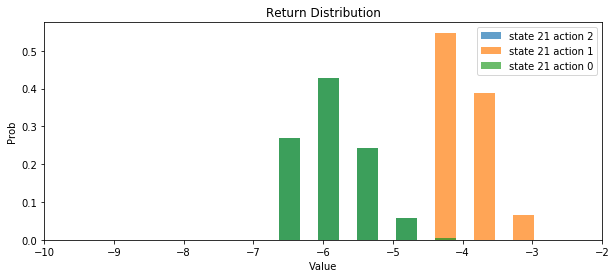

In [85]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[21, 2, :], width=0.3, label = 'state 21 action 2', linewidth = 5, alpha=0.7)
plt.bar(c51.z, c51.p[21, 1, :], width=0.3, label = 'state 21 action 1', linewidth = 5, alpha=0.7)
plt.bar(c51.z, c51.p[21, 0, :], width=0.3, label = 'state 21 action 0', linewidth = 5, alpha=0.7)
plt.legend()
plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

Text(0,0.5,'Prob')

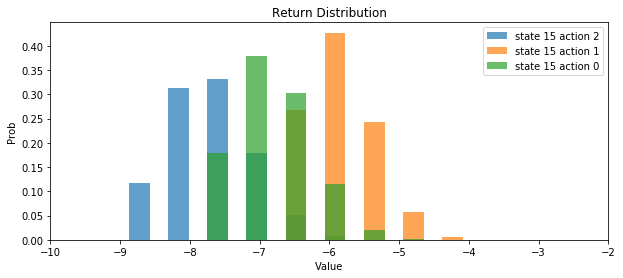

In [86]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[15, 2, :], width=0.3, label = 'state 15 action 2', linewidth = 5, alpha=0.7)
plt.bar(c51.z, c51.p[15, 1, :], width=0.3, label = 'state 15 action 1', linewidth = 5, alpha=0.7)
plt.bar(c51.z, c51.p[15, 0, :], width=0.3, label = 'state 15 action 0', linewidth = 5, alpha=0.7)
plt.legend()
plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

(30, 50)

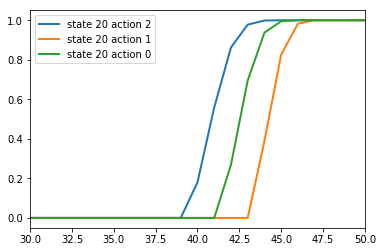

In [87]:
plt.plot(np.cumsum(c51.p[20, 2, :]), label = 'state 20 action 2', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 1, :]), label = 'state 20 action 1', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 0, :]), label = 'state 20 action 0', linewidth = 2)
plt.legend()
plt.xlim([30, 50])

In [88]:
### Running the same thing with CVaR action selection

In [13]:
env = GridWorld(10, 15, random_action_p=0.3)
config = Config(env.nS, env.nA)
config.Vmin = -30; config.Vmax = -2; config.gamma = 0.99; config.nAtoms=51
c51 = C51(config)
q = Qlearning(config)

num_episode = 5000
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.05, 1 + ep * ((0 - 9)/(num_episode)))
    alpha = max(0.001, 0.9 + ep * ((0 - 0.9)/(num_episode)))
    o = env.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(env.nA)
        else:
            a = np.argmax(c51.Q(o))
            #a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal = env.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        #q.observe(o, a, (r/100)+1, no, alpha)
        o = no
    returns[ep] = ret

Text(0,0.5,'Prob')

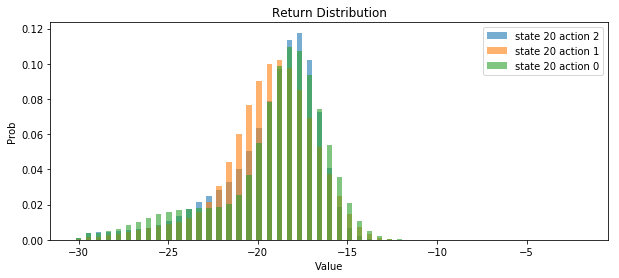

In [15]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[20, 2, :], width=0.3, label = 'state 20 action 2', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[20, 1, :], width=0.3, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[20, 0, :], width=0.3, label = 'state 20 action 0', linewidth = 5, alpha=0.6)
plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

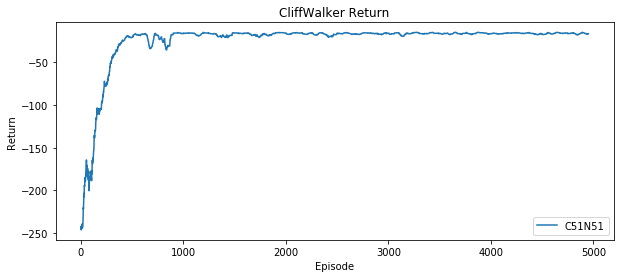

In [16]:
plt.figure(figsize=(10, 4))
plt.title('CliffWalker Return')
plt.plot(mv(returns, 50), label = 'C51N51')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return');

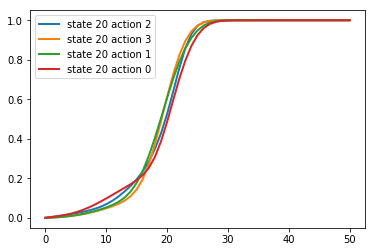

In [27]:
plt.plot(np.cumsum(c51.p[20, 2, :]), label = 'state 20 action 2', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 3, :]), label = 'state 20 action 3', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 1, :]), label = 'state 20 action 1', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 0, :]), label = 'state 20 action 0', linewidth = 2)
plt.xlim([])
plt.legend()

In [26]:
print(c51.CVaR(20, 0.1))

[-25.716 -25.352 -25.8   -24.4  ]
